In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass
import seaborn as sns
import matplotlib.pyplot as plt

password = getpass.getpass()

········


In [2]:
#2. Read the data into a Pandas dataframe.

connection_string="mysql+pymysql://root:" + password + "@localhost/bank"
engine=create_engine(connection_string)

query='''select f.film_id, f.title,f.release_year,f.language_id,f.original_language_id,f.rental_duration,f.rental_rate,f.length,f.replacement_cost,f.rating,f.special_features,
	r.rental_id,r.rental_date,r.inventory_id,r.customer_id,r.return_date,r.staff_id,i.store_id,
	case when month(r.rental_date) = 2 AND YEAR(r.rental_date) = 2006 
            THEN 'True' 
            ELSE 'False' 
       END AS rented_last_month
from sakila.inventory i
join sakila.film f on i.film_id = f.film_id
join sakila.rental r on i.inventory_id = r.inventory_id
'''
#also aplied the boolean requested in number 4


data=pd.read_sql_query(query,engine)
data.head()

,film_id,title,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,store_id,rented_last_month
0,1,ACADEMY DINOSAUR,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",4863,2005-07-08 19:03:15,1,431,2005-07-11 21:29:15,2,1,False
1,1,ACADEMY DINOSAUR,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",11433,2005-08-02 20:13:10,1,518,2005-08-11 21:35:10,1,1,False
2,1,ACADEMY DINOSAUR,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",14714,2005-08-21 21:27:43,1,279,2005-08-30 22:26:43,1,1,False
3,1,ACADEMY DINOSAUR,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",972,2005-05-30 20:21:07,2,411,2005-06-06 00:36:07,1,1,False
4,1,ACADEMY DINOSAUR,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2117,2005-06-17 20:24:00,2,170,2005-06-23 17:45:00,2,1,False


In [3]:
data["rented_last_month"].value_counts()

False    15862
True       182
Name: rented_last_month, dtype: int64

In [4]:
#3. Analyze extracted features and transform them. 
# You may need to encode some categorical variables, or scale numerical variables.

#4. Create a query to get the list of films and a boolean indicating if it was rented last month. 
#This would be our target variable.

data.dtypes

film_id                          int64
title                           object
release_year                     int64
language_id                      int64
original_language_id            object
rental_duration                  int64
rental_rate                    float64
length                           int64
replacement_cost               float64
rating                          object
special_features                object
rental_id                        int64
rental_date             datetime64[ns]
inventory_id                     int64
customer_id                      int64
return_date             datetime64[ns]
staff_id                         int64
store_id                         int64
rented_last_month               object
dtype: object

In [5]:
data.isna().sum()

film_id                     0
title                       0
release_year                0
language_id                 0
original_language_id    16044
rental_duration             0
rental_rate                 0
length                      0
replacement_cost            0
rating                      0
special_features            0
rental_id                   0
rental_date                 0
inventory_id                0
customer_id                 0
return_date               183
staff_id                    0
store_id                    0
rented_last_month           0
dtype: int64

In [6]:
data = data.drop(["original_language_id","return_date"],axis=1)

In [7]:
data.dtypes

film_id                       int64
title                        object
release_year                  int64
language_id                   int64
rental_duration               int64
rental_rate                 float64
length                        int64
replacement_cost            float64
rating                       object
special_features             object
rental_id                     int64
rental_date          datetime64[ns]
inventory_id                  int64
customer_id                   int64
staff_id                      int64
store_id                      int64
rented_last_month            object
dtype: object

In [8]:
cols=["film_id","rental_id","inventory_id","store_id","language_id","customer_id","staff_id"]
for col in cols:
    data[col]=data[col].astype("object")
data.dtypes

film_id                      object
title                        object
release_year                  int64
language_id                  object
rental_duration               int64
rental_rate                 float64
length                        int64
replacement_cost            float64
rating                       object
special_features             object
rental_id                    object
rental_date          datetime64[ns]
inventory_id                 object
customer_id                  object
staff_id                     object
store_id                     object
rented_last_month            object
dtype: object

In [9]:
import datetime as dt

data["rental_date"]=data["rental_date"].map(dt.datetime.toordinal)

data["rented_last_month"] = data["rented_last_month"].replace({"True": True, "False": False}).astype(bool)

data.dtypes

film_id               object
title                 object
release_year           int64
language_id           object
rental_duration        int64
rental_rate          float64
length                 int64
replacement_cost     float64
rating                object
special_features      object
rental_id             object
rental_date            int64
inventory_id          object
customer_id           object
staff_id              object
store_id              object
rented_last_month       bool
dtype: object

In [10]:
# Y defined and splitiing beetween numeric and categ

Y=data["rented_last_month"]
data_x = data.drop(["rented_last_month"],axis=1)

import numpy as np
numeric = data_x.select_dtypes(include=[np.number])
categoric = data_x.select_dtypes(include=[np.object])

C:\Users\simoe\AppData\Local\Temp\ipykernel_43576\4156550173.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoric = data_x.select_dtypes(include=[np.object])


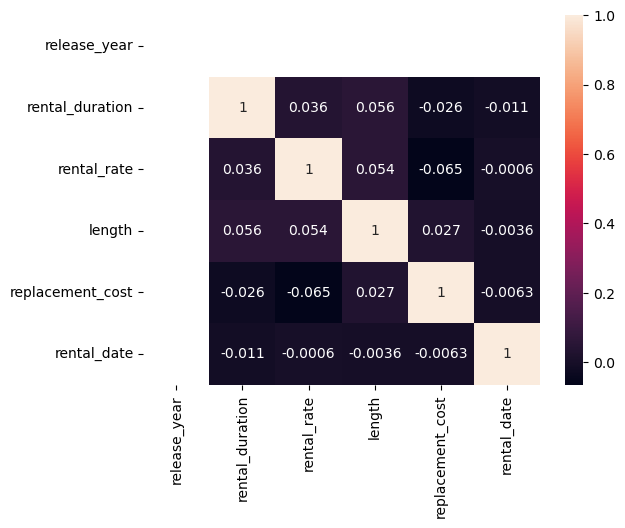

In [11]:
corr_matrix = numeric.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

categoric=categoric.drop(["title"],axis=1)

In [12]:
#apply normalizer
from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(numeric)
numeric_normalized=transformer.transform(numeric)
numeric_x=pd.DataFrame(numeric_normalized)
numeric_x.columns=numeric.columns
numeric_x.head()

,release_year,rental_duration,rental_rate,length,replacement_cost,rental_date
0,0.00274,0.000008,0.000001,0.000117,0.000029,0.999996
1,0.00274,0.000008,0.000001,0.000117,0.000029,0.999996
2,0.00274,0.000008,0.000001,0.000117,0.000029,0.999996
3,0.00274,0.000008,0.000001,0.000117,0.000029,0.999996
4,0.00274,0.000008,0.000001,0.000117,0.000029,0.999996


In [13]:
categoric_x=pd.get_dummies(categoric,columns=categoric.columns)
categoric_x

C:\Users\simoe\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,film_id_1,film_id_2,film_id_3,film_id_4,film_id_5,film_id_6,film_id_7,film_id_8,film_id_9,film_id_10,...,customer_id_594,customer_id_595,customer_id_596,customer_id_597,customer_id_598,customer_id_599,staff_id_1,staff_id_2,store_id_1,store_id_2
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
16040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
16041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
16042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [14]:
X = np.concatenate((numeric_x,categoric_x),axis=1)

In [15]:
# 5.Create a logistic regression model to predict this variable from the cleaned data.

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=100)

from sklearn.linear_model import LogisticRegression

classification=LogisticRegression().fit(X_train,y_train)

predictions=classification.predict(X_test)
predictions

array([False, False, False, ..., False, False, False])

In [16]:
classification.score(X_test,y_test)

0.9867054424594931

In [17]:
y_test.value_counts()

False    4750
True       64
Name: rented_last_month, dtype: int64

In [18]:
pd.Series(predictions).value_counts()

False    4814
dtype: int64

In [20]:
pip install imbalanced-learn


     -------------------------------------- 226.0/226.0 kB 4.7 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

# Apply oversampling to balance the dataset
#oversampler = RandomOverSampler(sampling_strategy='minority')
#X_balanced, y_balanced = oversampler.fit_resample(X, Y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=100)

# Train logistic regression model with class weights
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions on test set
predictions = model.predict(X_test)

C:\Users\simoe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
y_test.value_counts()

False    6342
True       76
Name: rented_last_month, dtype: int64

In [23]:
pd.Series(predictions).value_counts()

False    6386
True       32
dtype: int64

In [24]:
model.score(X_test,y_test)

0.9831723278279838

In [25]:
#6. Evaluate the results.

data

,film_id,title,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,rental_id,rental_date,inventory_id,customer_id,staff_id,store_id,rented_last_month
0,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",4863,732135,1,431,2,1,False
1,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",11433,732160,1,518,1,1,False
2,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",14714,732179,1,279,1,1,False
3,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",972,732096,2,411,1,1,False
4,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2117,732114,2,170,2,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16039,1000,ZORRO ARK,2006,1,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",711,732095,4581,215,2,2,False
16040,1000,ZORRO ARK,2006,1,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",1493,732112,4581,235,2,2,False
16041,1000,ZORRO ARK,2006,1,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",6712,732139,4581,226,2,2,False
16042,1000,ZORRO ARK,2006,1,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",9701,732158,4581,401,2,2,False


In [26]:
data["rented_nextmonth"]=model.predict(X)
data

,film_id,title,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,rental_id,rental_date,inventory_id,customer_id,staff_id,store_id,rented_last_month,rented_nextmonth
0,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",4863,732135,1,431,2,1,False,False
1,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",11433,732160,1,518,1,1,False,False
2,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",14714,732179,1,279,1,1,False,False
3,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",972,732096,2,411,1,1,False,False
4,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2117,732114,2,170,2,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16039,1000,ZORRO ARK,2006,1,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",711,732095,4581,215,2,2,False,False
16040,1000,ZORRO ARK,2006,1,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",1493,732112,4581,235,2,2,False,False
16041,1000,ZORRO ARK,2006,1,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",6712,732139,4581,226,2,2,False,False
16042,1000,ZORRO ARK,2006,1,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",9701,732158,4581,401,2,2,False,False


In [27]:
data_rented_nextmonth = data[data['rented_nextmonth'] == True]
data_rented_nextmonth = data_rented_nextmonth[["title", "rented_last_month", "rented_nextmonth"]]
data_rented_nextmonth

,title,rented_last_month,rented_nextmonth
23,ACE GOLDFINGER,False,True
24,ACE GOLDFINGER,True,True
224,ALI FOREVER,True,True
261,ALONE TRIP,False,True
262,ALONE TRIP,True,True
...,...,...,...
15886,WORLD LEATHERNECKS,False,True
15887,WORLD LEATHERNECKS,True,True
15990,ZHIVAGO CORE,False,True
15992,ZHIVAGO CORE,False,True


In [28]:
unique_titles = data_rented_nextmonth['title'].unique()
print("Movies that will most likely be rented: ", unique_titles)

Movies that will most likely be rented:  ['ACE GOLDFINGER' 'ALI FOREVER' 'ALONE TRIP' 'AMADEUS HOLY'
 'AMISTAD MIDSUMMER' 'ARMAGEDDON LOST' 'BASIC EASY' 'BERETS AGENT'
 'BLADE POLISH' 'BLANKET BEVERLY' 'CAMELOT VACATION' 'CANDIDATE PERDITION'
 'CENTER DINOSAUR' 'CLEOPATRA DEVIL' 'CLUB GRAFFITI'
 'CREATURES SHAKESPEARE' 'CYCLONE FAMILY' 'DANCES NONE' 'DAY UNFAITHFUL'
 'DEEP CRUSADE' 'DETAILS PACKER' 'DEVIL DESIRE' 'DIVINE RESURRECTION'
 'DOORS PRESIDENT' 'DRAGONFLY STRANGERS' 'DRIFTER COMMANDMENTS'
 'EAGLES PANKY' 'EARTH VISION' 'EFFECT GLADIATOR' 'ENCINO ELF'
 'ENOUGH RAGING' 'FAMILY SWEET' 'FIGHT JAWBREAKER' 'GABLES METROPOLIS'
 'GLEAMING JAWBREAKER' 'GRAIL FRANKENSTEIN' 'GUNFIGHT MOON'
 'HALF OUTFIELD' 'HAPPINESS UNITED' 'HARRY IDAHO' 'HAUNTED ANTITRUST'
 'HOLES BRANNIGAN' 'HUNGER ROOF' 'HYDE DOCTOR' 'IGBY MAKER'
 'INSIDER ARIZONA' 'INTENTIONS EMPIRE' 'JASON TRAP' 'JUGGLER HARDLY'
 'LADY STAGE' 'LAWLESS VISION' 'LOATHING LEGALLY' 'LORD ARIZONA'
 'MIDNIGHT WESTWARD' 'MOCKINGBIRD HOLLY